## Introduction to Image Captioning

Image Captioning is a fascinating way for computers to describe images using words. Similar to how we glance at a picture and understand what's happening, computers can learn to do the same!


Imagine showing a computer an image of an adorable cat. Image Captioning is like magic that makes the computer say something like, "A fluffy white cat is sitting on a windowsill." It's a beautiful blend of teaching computers to comprehend images and communicate using human-like language.

## How It Works

Think of Image Captioning as a collaboration between two essential components of the computer's brain:



### The Eye (Convolutional Neural Networks - CNNs):

Just as we have eyes to see, computers have CNNs to analyze pictures. These networks help the computer identify important elements in the image, such as the cat's ears or tail. These key elements are translated into a special set of numbers that the computer understands. These special numbers are called "vector embeddings."



### The Mouth (Recurrent Neural Networks - RNNs):

The computer's "mouth" is the RNN. It takes those special numbers (vector embeddings) from the CNN and combines them with the power of words. It's as if we're teaching the computer to narrate a story about the image. The RNN takes one word at a time and starts forming a sentence. It begins with "Fluffy," followed by "white," and so on, until a complete description is created.



## Why It's Fascinating

Image Captioning empowers computers to describe images just like humans do. This enhances computers' image understanding capabilities and enables them to communicate using descriptive language. If you're curious to see how this collaboration looks in visual representation, check out the Modelling section!

In [3]:
!nvidia-smi

Thu Nov  7 21:43:08 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.90.07              Driver Version: 550.90.07      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   61C    P8             12W /   70W |       1MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Importing the relevant libraries

In [4]:
# Basic libraries
import os
import pickle
import cv2, warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
from glob import glob
from math import ceil
from collections import defaultdict
from tqdm.notebook import tqdm  # Progress bar library for Jupyter Notebook
tqdm.pandas()
from sklearn.model_selection import train_test_split

# Deep learning framework for building and training models
import tensorflow as tf

# Pre-trained model for image feature extraction
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Tokenizer class for captions tokenization
from tensorflow.keras.preprocessing.text import Tokenizer

# Function for padding sequences to a specific length
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Optimizer for training the model
from tensorflow.keras.optimizers import Adam

# Class for defining Keras models
from tensorflow.keras.models import Model, Sequential

from tensorflow.keras.utils import to_categorical, plot_model

from tensorflow.keras.layers import Input, Dense, Flatten, LSTM, TimeDistributed, Embedding, Dropout, add, Concatenate, Bidirectional, Dot, Activation, RepeatVector, Multiply, Lambda, Convolution2D

#To prevent overfitting
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import regularizers

# Image Augumentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# For checking score
from nltk.translate.bleu_score import corpus_bleu

## Loading the images

In [5]:
img_path = '/kaggle/input/flickr8k/Images/'
images = glob(img_path+'*.jpg')
images[:5]

['/kaggle/input/flickr8k/Images/3226254560_2f8ac147ea.jpg',
 '/kaggle/input/flickr8k/Images/214543992_ce6c0d9f9b.jpg',
 '/kaggle/input/flickr8k/Images/2366643786_9c9a830db8.jpg',
 '/kaggle/input/flickr8k/Images/3368819708_0bfa0808f8.jpg',
 '/kaggle/input/flickr8k/Images/2190227737_6e0bde2623.jpg']

In [6]:
len(images)

8091

## Loading the captions

In [7]:
captions = open('/kaggle/input/flickr8k/captions.txt','rb').read().decode('utf-8').split('\n')
captions[:5]

['image,caption',
 '1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .',
 '1000268201_693b08cb0e.jpg,A girl going into a wooden building .',
 '1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .',
 '1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .']

In [8]:
len(captions)

40457

## Image Features Extraction

When it comes to understanding images, we need a helping hand from specialized models. Here's where the pre-trained VGG16 model steps in. This model is like a superhero for extracting important details from images, helping us understand what's happening.





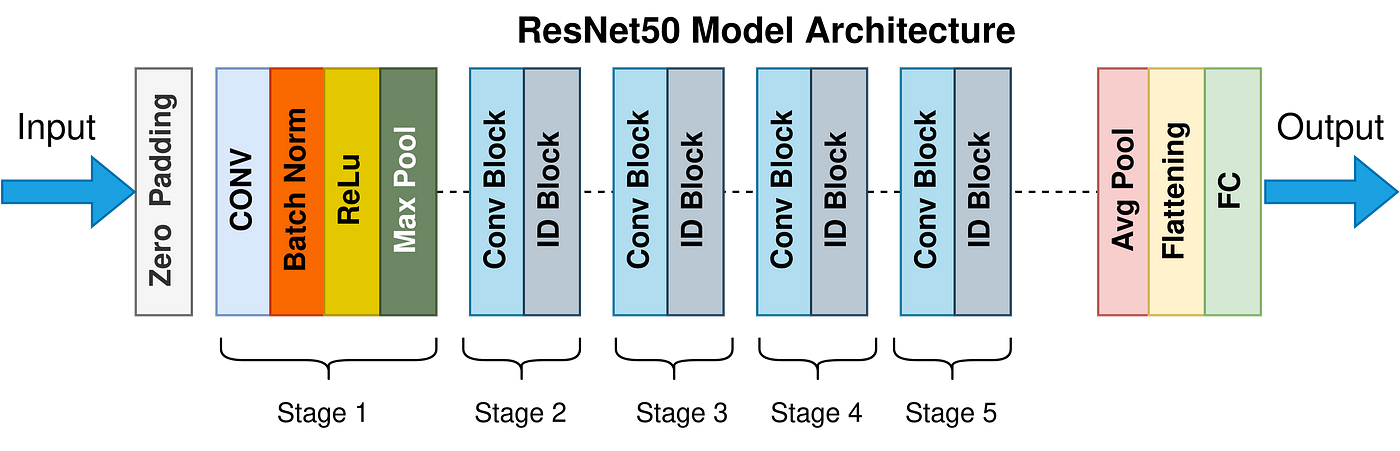





## Resnet50

ResNet-50, a 50-layer deep convolutional neural network, is widely used in image captioning tasks for its strong feature extraction capabilities. Built on a residual learning framework, ResNet-50 efficiently captures complex visual features by using "shortcut" or residual connections, which help the model avoid issues like vanishing gradients in deep networks.



For image captioning, ResNet-50 serves as the backbone of the encoder in an encoder-decoder framework. It processes an input image to generate a rich, high-level feature map that captures essential visual details, which is then fed into a decoder (often an LSTM or Transformer) to produce descriptive captions.

## Downloading the ResNet50 inception model

In [9]:
# Load the ResNet50 model
model = ResNet50(include_top=True)

# Printing the model summary
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [10]:
penultimate_layer_output = model.layers[-2].output  # Output of the penultimate layer
model = Model(inputs=model.input, outputs=penultimate_layer_output)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

## Extracting features from images

In [11]:
img_features = {}
count = 0

for img_path in tqdm(images):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img = cv2.resize(img,(224,224)) # ResNet model requires images of dimensions (224,224,3)
    img = img.reshape(1,224,224,3) # Reshaping image to the dimensions of a single image
    features = model.predict(img).reshape(2048,) # Feature extraction from images
    img_name = img_path.split('/')[-1] # Extracting image name
    img_features[img_name] = features
    count += 1
    # Fetching the features of only 2000 images as using more than 2000 images leads to overloading memory issues
    if count == 2000:
        break
    if count % 50 == 0:
        print(count)

  0%|          | 0/8091 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step
50
1/1 [==============================] - 0s 30ms/step
100
1/1 [==============================] - 0s 29ms/step
150
1/1 [==============================] - 0s 27ms/step
200
1/1 [==============================] - 0s 30ms/step
250
1/1 [==============================] - 0s 27ms/step
300
1/1 [==============================] - 0s 26ms/step
350
1/1 [==============================] - 0s 27ms/step
400
1/1 [==============================] - 0s 27ms/step
450
1/1 [==============================] - 0s 27ms/step
500
1/1 [==============================] - 0s 27ms/step
550
1/1 [==============================] - 0s 29ms/step
600
1/1 [==============================] - 0s 28ms/step
650
1/1 [==============================] - 0s 30ms/step
700
1/1 [==============================] - 0s 28ms/step
750
1/1 [==============================] - 0s 26ms/step
800
1/1 [==============================] - 0s 28ms/step
850
1/1 [==============================] - 0s 28ms/st

In [12]:
len(img_features)

2000

In [13]:
# Save the extracted features to a .pkl file in the output directory
with open('/kaggle/working/image_features.pkl', 'wb') as f:
    pickle.dump(img_features, f)

print("Features saved to /kaggle/working/image_features.pkl")

Features saved to /kaggle/working/image_features.pkl


In [14]:
# Load the extracted features from the .pkl file
with open('/kaggle/working/image_features.pkl', 'rb') as f:
    img_features = pickle.load(f)

print("Features loaded successfully")

Features loaded successfully


## Preprocessing the captions text

In [15]:
captions = captions[1:]
captions[:5]

['1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .',
 '1000268201_693b08cb0e.jpg,A girl going into a wooden building .',
 '1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .',
 '1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .',
 '1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .']

In [16]:
captions[8].split(',')[1]

'Two dogs of different breeds looking at each other on the road .'

In [17]:
captions_dict = {}

for cap in captions:
    try:
        img_name = cap.split(',')[0]
        caption = cap.split(',')[1]
        # Each image has 5 captions
        if img_name in img_features:
            if img_name not in captions_dict:
                captions_dict[img_name] = [caption] # Storing the first caption
            else:
                captions_dict[img_name].append(caption) # Adding the remaining captions 
    except:
        break

In [18]:
len(captions_dict)

2000

In [19]:
def text_preprocess(text):
    modified_text = text.lower() # Converting text to lowercase
    modified_text = 'startofseq ' + modified_text + ' endofseq' # Appending the special tokens at the beginning and ending of text
    return modified_text

In [20]:
# Storing the preprocessed text within the captions dictionary
for key, val in captions_dict.items():
    for item in val:
        captions_dict[key][val.index(item)] = text_preprocess(item)

## Creating vocabulary of the entire text corpus

In [21]:
count_words = dict()
cnt = 1

for key, val in captions_dict.items(): # Iterating through all images with keys as images and their values as 5 captions
    for item in val: # Iterating through all captions for each image
        for word in item.split(): # Iterating through all words in each caption
            if word not in count_words:
                count_words[word] = cnt
                cnt += 1

In [22]:
len(count_words) # Vocab size

4656

In [23]:
# Encoding the text by assigning each word to its corresponding index in the vocabulary i.e. count_words dictionary
for key, val in captions_dict.items():
    for caption in val:
        encoded = []
        for word in caption.split():
            encoded.append(count_words[word])
        captions_dict[key][val.index(caption)] = encoded

In [24]:
# Determining the maximum possible length of text within the entire captions text corpus
max_len = -1

for key, value in captions_dict.items():
    for caption in value:
        if max_len < len(caption):
            max_len = len(caption)

In [25]:
max_len

34

In [26]:
vocab_size = len(count_words) # Vocab size is the total number of words present in count_words dictionary
vocab_size

4656

## Building a custom generator function to generate input image features, previously generated text and the text to be generated as output

In [27]:
def generator(img,caption):
    X = []
    y_input = []
    y_output = []
    
    for key, val in caption.items(): 
        for item in val: 
            for i in range(1,len(item)):
                X.append(img[key]) # Appending the input image features
                input_seq = [item[:i]] # Previously generated text to be used as input to predict the next word 
                output_seq = item[i] # The next word to be predicted as output
                # Padding encoded text sequences to the maximum length
                input_seq = pad_sequences(input_seq,maxlen=max_len,padding='post',truncating='post')[0] 
                # One Hot encoding the output sequence with vocabulary size as the total no. of classes
                output_seq = to_categorical([output_seq],num_classes=vocab_size+1)[0]
                y_input.append(input_seq)
                y_output.append(output_seq)
    
    return X, y_input, y_output

In [28]:
X, y_in, y_out = generator(img_features,captions_dict)

In [29]:
len(X), len(y_in), len(y_out)

(122453, 122453, 122453)

In [30]:
# Converting input and output into Numpy arrays for faster processing
X = np.array(X)
y_in = np.array(y_in,dtype='float64')
y_out = np.array(y_out,dtype='float64')

In [31]:
X.shape, y_in.shape, y_out.shape

((122453, 2048), (122453, 34), (122453, 4657))

## LSTM
We've got our image features, and we're ready to make our captions come to life. In this section, we'll be diving into the training of our LSTM model. This is where we teach our model to generate descriptive captions for our images.



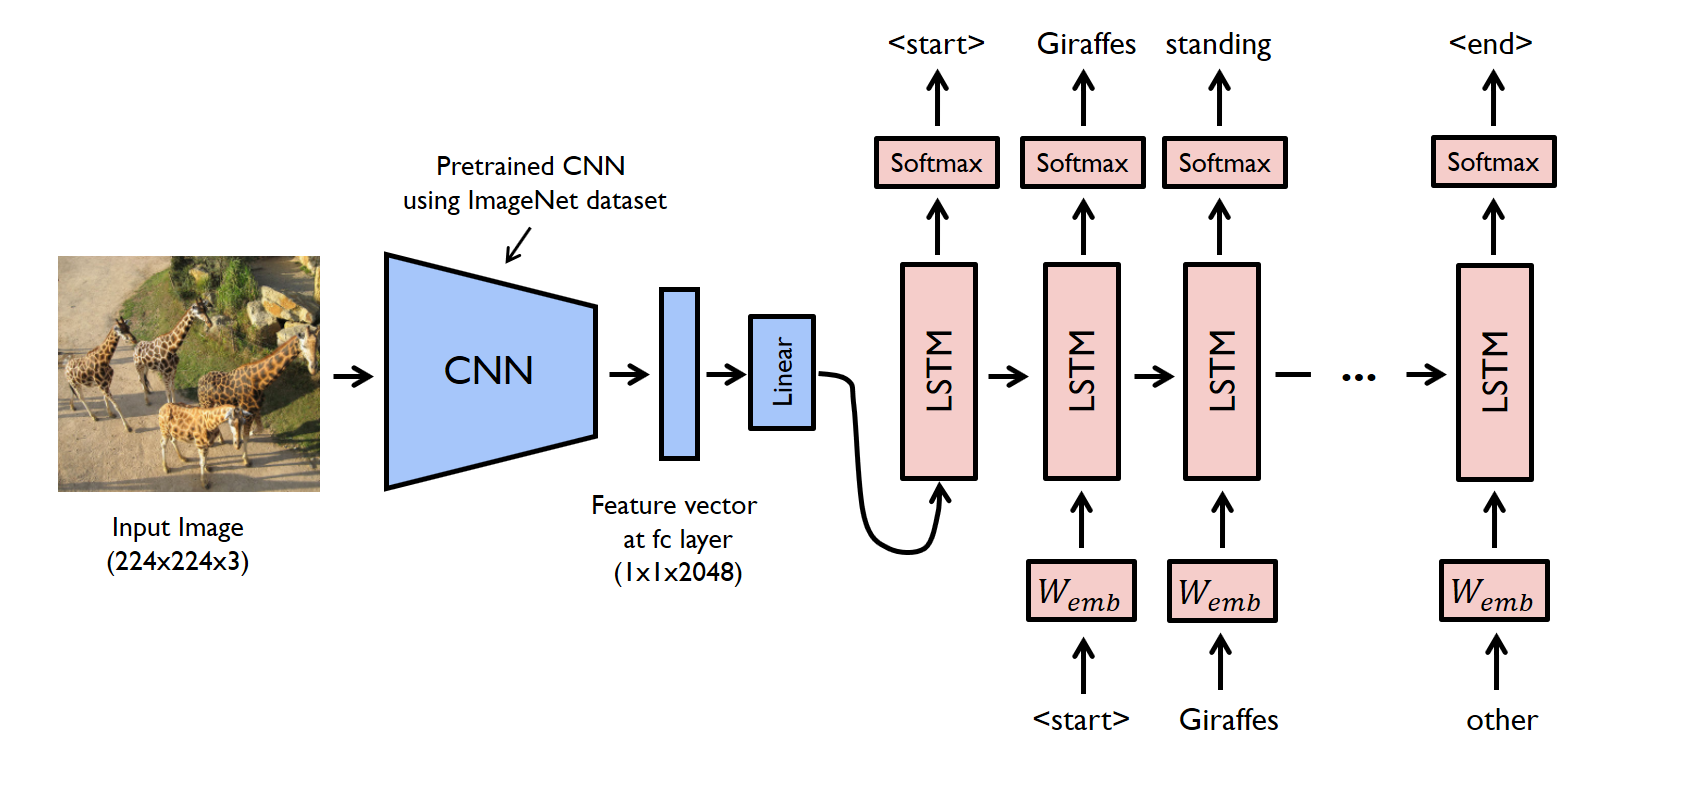

## Establishing the model architecture

In [33]:
# Parameters
embedding_len = 128
MAX_LEN = max_len
vocab_size = len(count_words)

# Image model (encoder)
img_model = Sequential()
img_model.add(Dense(embedding_len, input_shape=(2048,), activation='relu'))
img_model.add(RepeatVector(MAX_LEN))
img_model.summary()

# Caption model (decoder) with dropout
captions_model = Sequential()
captions_model.add(Embedding(input_dim=vocab_size + 1, output_dim=embedding_len, input_length=MAX_LEN))
captions_model.add(LSTM(256, return_sequences=True))
captions_model.add(Dropout(0.1))  # Dropout directly after the LSTM layer
captions_model.add(TimeDistributed(Dense(embedding_len)))
captions_model.add(Dropout(0.1))  # Dropout after TimeDistributed layer

# Concatenate encoder and decoder outputs
concat_output = Concatenate()([img_model.output, captions_model.output])
output = LSTM(units=128, return_sequences=True)(concat_output)  # First LSTM layer
output = Dropout(0.1)(output)
output = LSTM(units=512, return_sequences=False)(output)        # Second LSTM layer
output = Dropout(0.1)(output)
output = Dense(units=vocab_size + 1, activation='softmax')(output)  # Output layer

# Create and compile the model
final_model = Model(inputs=[img_model.input, captions_model.input], outputs=output)
final_model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
final_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 128)               262272    
                                                                 
 repeat_vector_1 (RepeatVect  (None, 34, 128)          0         
 or)                                                             
                                                                 
Total params: 262,272
Trainable params: 262,272
Non-trainable params: 0
_________________________________________________________________
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 embedding_1_input (InputLayer)  [(None, 34)]        0           []                               
                                                                

## Visualizing the model architecture

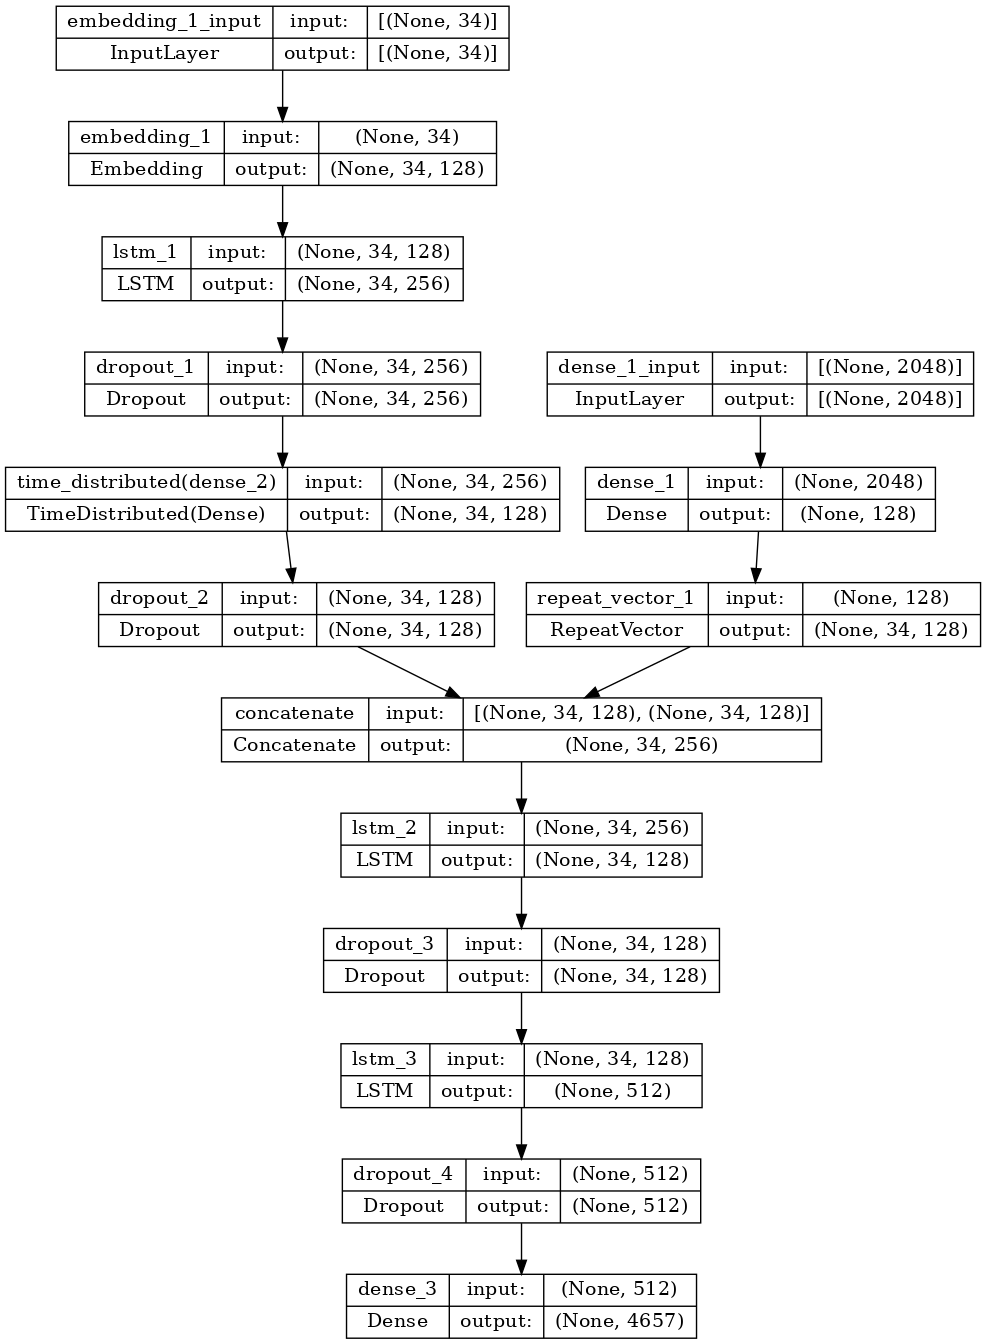

In [34]:
plot_model(final_model,'model.png',show_shapes=True,dpi=100)

In [35]:
# Split the data into training and validation sets (80% train, 20% validation)
X_train, X_val, y_in_train, y_in_val, y_out_train, y_out_val = train_test_split(
    X, y_in, y_out, test_size=0.2, random_state=42)

## Model training

In [36]:
# Split the data into training and validation sets (80% train, 20% validation)
X_train, X_val, y_in_train, y_in_val, y_out_train, y_out_val = train_test_split(
    X, y_in, y_out, test_size=0.1, random_state=42
)

# Define the ModelCheckpoint callback
mc = ModelCheckpoint(
    'image_caption_generator_best_model.h5', 
    monitor='val_loss',  # You can monitor any metric like 'val_loss' or 'val_accuracy'
    verbose=1, 
    mode='min',  # Use 'min' for loss, 'max' for accuracy
    save_best_only=True)

# Define the EarlyStopping callback
es = EarlyStopping(
    monitor='val_loss',  # You can monitor other metrics like 'val_accuracy'
    patience=3,  # Number of epochs with no improvement before stopping
    verbose=1,
    mode='min',  # 'min' for loss, 'max' for accuracy
    restore_best_weights=True)  # Restore the best weights after early stopping

# Train the model with both callbacks
history = final_model.fit([X_train, y_in_train],
                          y_out_train,
                          batch_size=512,
                          callbacks=[mc,es],  # List of callbacks
                          epochs=200,
                          validation_data=([X_val, y_in_val], y_out_val))  # Validation data

Epoch 1/200
216/216 [==============================] - ETA: 0s - loss: 5.3517 - accuracy: 0.1120
Epoch 1: val_loss improved from inf to 5.18889, saving model to image_caption_generator_best_model.h5
216/216 [==============================] - 36s 134ms/step - loss: 5.3517 - accuracy: 0.1120 - val_loss: 5.1889 - val_accuracy: 0.0921
Epoch 2/200
216/216 [==============================] - ETA: 0s - loss: 5.1849 - accuracy: 0.1161
Epoch 2: val_loss improved from 5.18889 to 5.11203, saving model to image_caption_generator_best_model.h5
216/216 [==============================] - 22s 103ms/step - loss: 5.1849 - accuracy: 0.1161 - val_loss: 5.1120 - val_accuracy: 0.1298
Epoch 3/200
216/216 [==============================] - ETA: 0s - loss: 5.1249 - accuracy: 0.1182
Epoch 3: val_loss improved from 5.11203 to 5.06503, saving model to image_caption_generator_best_model.h5
216/216 [==============================] - 21s 95ms/step - loss: 5.1249 - accuracy: 0.1182 - val_loss: 5.0650 - val_accuracy: 0

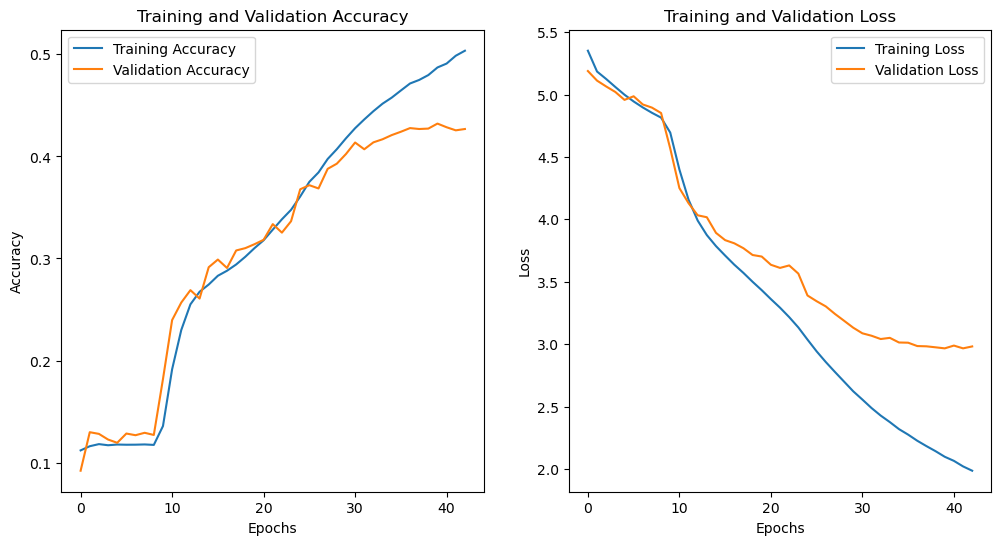

In [37]:
# Plotting training & validation accuracy and loss
plt.figure(figsize=(12, 6))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Show the plots
plt.show()

In [38]:
# Creating an inverse dictionary with reverse key-value pairs
inverse_dict = {val: key for key,val in count_words.items()}

## Saving the final trained model and the vocabulary dictionary

In [39]:
final_model.save('image_caption_generator.h5')

In [40]:
np.save('vocab.npy', count_words) # Save count_words dictionary
np.save('inverse_vocab.npy', inverse_dict)  # Save inverse dictionary as well

In [41]:
# Load the saved vocabularies (for reuse or separate testing script)
count_words = np.load('vocab.npy', allow_pickle=True).item()
inverse_dict = np.load('inverse_vocab.npy', allow_pickle=True).item()

## Generating sample predictions

In [42]:
# Custom function for extracting an image and transforming it into an appropriate format
def getImage(idx):
    test_img_path = images[idx]
    test_img = cv2.imread(test_img_path)
    test_img = cv2.cvtColor(test_img,cv2.COLOR_BGR2RGB)
    test_img = cv2.resize(test_img,(224,224))
    test_img = np.reshape(test_img,(1,224,224,3))
    return test_img

1/1 [==============================] - 0s 24ms/step


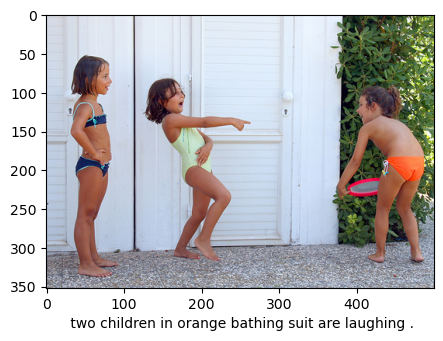

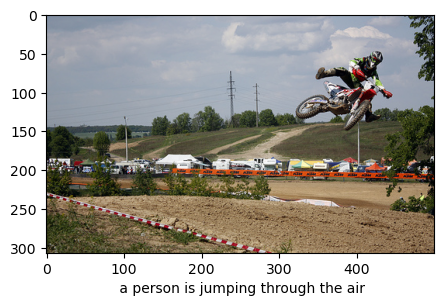

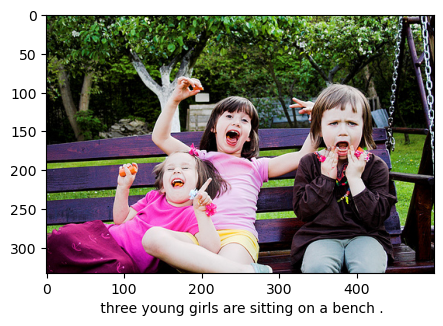

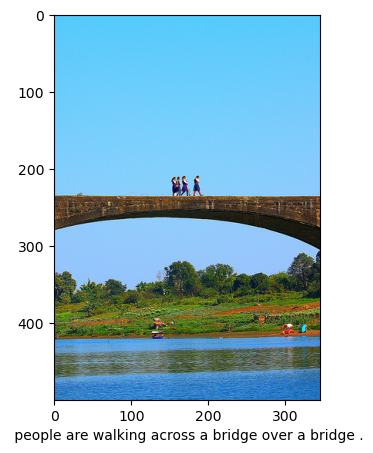

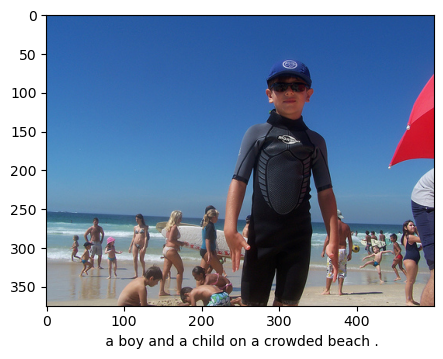

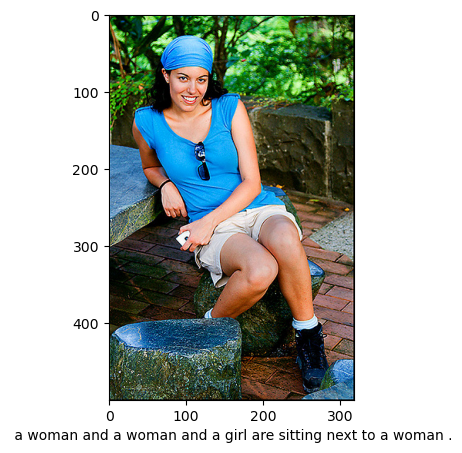

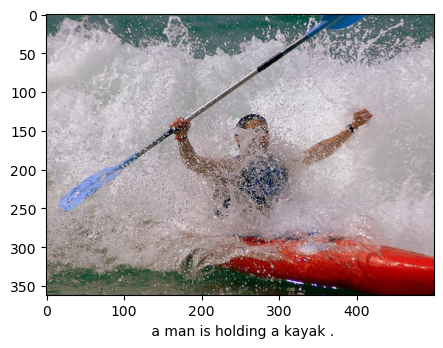

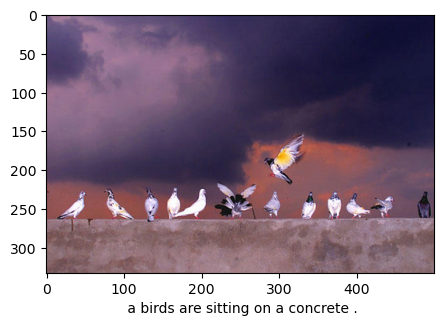

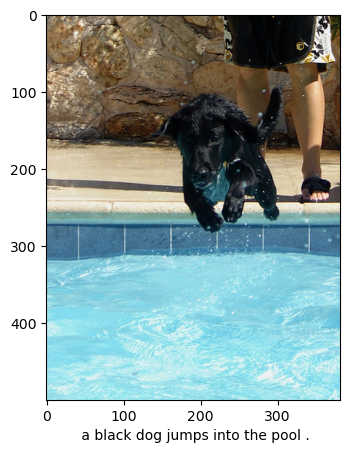

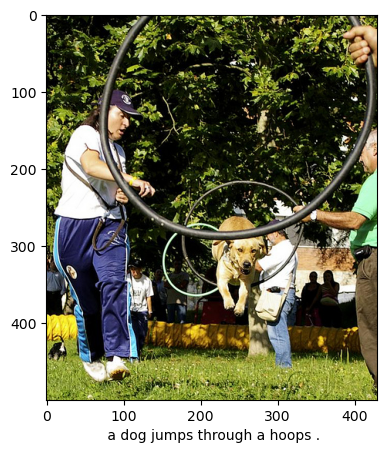

In [43]:
for i in range(10):
    random_no = np.random.randint(0,1501,(1,1))[0,0]
    test_feature = model.predict(getImage(random_no)).reshape(1,2048)
    test_img_path = images[random_no]
    test_img = cv2.imread(test_img_path)
    test_img = cv2.cvtColor(test_img,cv2.COLOR_BGR2RGB)
    pred_text = ['startofseq']
    count = 0
    caption = '' # Stores the predicted captions text
    
    while count < 25:
        count += 1
        # Encoding the captions text with numbers
        encoded = []
        
        for i in pred_text:
            encoded.append(count_words[i])
        
        encoded = [encoded]
        # Padding the encoded text sequences to maximum length
        encoded = pad_sequences(encoded,maxlen=MAX_LEN,padding='post',truncating='post')
        pred_idx = np.argmax(final_model.predict([test_feature,encoded])) # Fetching the predicted word index having the maximum probability of occurrence
        sampled_word = inverse_dict[pred_idx] # Extracting the predicted word by its respective index
        # Checking for ending of the sequence
        if sampled_word == 'endofseq':
            break
        caption = caption + ' ' + sampled_word
        pred_text.append(sampled_word)
    
    plt.figure(figsize=(5,5))
    plt.imshow(test_img)
    plt.xlabel(caption)